<a href="https://colab.research.google.com/github/solislemuslab/dna-nn-theory/blob/master/scripts/histone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

versions
- v1: two Conv2D
- v2: two Conv2D with l2 regularization
- v3: one Conv1D, two Conv2D
- v4: one Conv1D, one Conv2D

# Setup

In [ ]:
!pip install -q biopython

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/My Drive/data/histone/'
LOG_DIR = '/content/drive/My Drive/dna-nn/histone/'

# module auto reload
%load_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# copy modules
!cp -r '/content/drive/My Drive/dna_nn' .
!ls dna_nn

download.py  load.py  __pycache__


In [ ]:
import gc

from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset

from dna_nn.load import read_fasta, encode, encoded_shape, gen_from_arrays

In [ ]:
files = ['H3',      'H4',      'H3K9ac',  'H3K14ac',  'H4ac',
         'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K36me3', 'H3K79me3']
files = [DATA_DIR + file + '.fasta' for file in files]

In [ ]:
pd.read_html('http://www.jaist.ac.jp/~tran/nucleosome/members.htm', header=0)[1]

,Datasets,#positive,#negative,Description
0,H3,7667,7298,H3 occupancy
1,H4,6480,8121,H4 occupancy
2,H3K9ac,15415,12367,H3K9 acetylation relative to H3
3,H3K14ac,18771,14277,H3K14 acetylation relative to H3
4,H4ac,18410,15685,H4 acetylation relative to H3
5,H3K4me1,17266,14411,H3K4 monomethylation relative to H3
6,H3K4me2,18143,12540,H3K4 dimethylation relative to H3
7,H3K4me3,19604,17195,H3K4 trimethylation relative to H3
8,H3K36me3,18892,15988,H3K36 trimethylation relative to H3
9,H3K79me3,15337,13500,H3K79 trimethylation relative to H3


# Create dataset

In [ ]:
# load
sequences, labels = read_fasta(files[0])
gen = gen_from_arrays(sequences, labels, encode(1, 2))

14963 samples loaded


In [ ]:
# split
test_size = 0.15
val_size = 0.15

split_options = dict(test_size=test_size, stratify=labels, random_state=3264)
x_train_val, x_test, y_train_val, y_test = train_test_split(sequences, labels, **split_options)
# normalize val_size and update options
split_options.update(dict(test_size=val_size/(1-test_size), stratify=y_train_val))
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, **split_options)
del x_train_val, y_train_val
print('train size:', len(x_train))
print('test size: ', len(x_val))
print('val size:  ', len(x_test))

train size: 10473
test size:  2245
val size:   2245


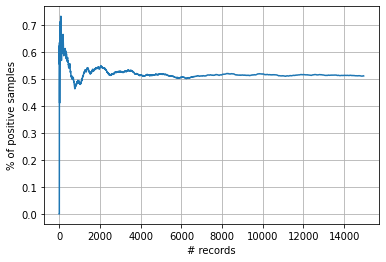

In [ ]:
def class_distribution(labels):
    y = pd.Series(labels)
    positive_pctg = y.cumsum() / y.index
    ax = positive_pctg.plot()
    ax.set_xlabel('# records')
    ax.set_ylabel('% of positive samples')
    ax.grid()

class_distribution(labels)

In [ ]:
# generators
word_size = 3
region_size = 0

encode_func = encode(word_size, region_size)
x_shape = encoded_shape(sequences[0], word_size, region_size)

train_gen = gen_from_arrays(x_train, y_train, encode_func)
val_gen = gen_from_arrays(x_val, y_val, encode_func)
test_gen = gen_from_arrays(x_test, y_test, encode_func)

# datasets
batch_size = 32
prefetch = tf.data.experimental.AUTOTUNE

output_shapes = (x_shape, ())
output_types = (tf.float32, tf.float32)

train_ds = Dataset.from_generator(train_gen, output_types, output_shapes)
train_ds = train_ds.shuffle(500).batch(batch_size).prefetch(prefetch)

test_ds = Dataset.from_generator(test_gen, output_types, output_shapes)
test_ds = test_ds.batch(batch_size).prefetch(prefetch)

print('x shape:', train_ds.element_spec[0].shape)
print('y shape:', train_ds.element_spec[1].shape)

x shape: (None, 498, 64, 1)
y shape: (None,)


In [ ]:
x_val_encode, y_val_encode = [], []
for x, y in val_gen():
    x_val_encode.append(x)
    y_val_encode.append(y)
x_val_encode = np.array(x_val_encode)
y_val_encode = np.array(y_val_encode)
validation_data = (x_val_encode, y_val_encode)

# Build model

In [ ]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(128, 3, activation='relu', input_shape=x_shape),
    keras.layers.GlobalMaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
              metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 496, 62, 128)      1280      
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 5,474
Trainable params: 5,474
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model.evaluate(test_dataset)

In [ ]:
version = 'v4-base'

def scheduler(epoch, lr):
    return lr if (epoch % 10) else lr / 10

callbacks = [
    # keras.callbacks.CSVLogger(LOG_PATH + f'{version}.csv'),
    # keras.callbacks.TensorBoard(log_dir=LOG_PATH + f'log/{version}/'),
    # keras.callbacks.LambdaCallback(
    #     on_epoch_end=lambda epoch, logs: gc.collect(),
    #     on_train_end=lambda logs: model.save(LOG_PATH + f'{version}.h5')
    # ),
    # keras.callbacks.LearningRateScheduler(scheduler),
]

history = model.fit(train_ds, validation_data=validation_data, epochs=1,
                    callbacks=callbacks)

328/328 [==============================] - 37s 112ms/step - loss: 0.6883 - accuracy: 0.5628 - val_loss: 0.6864 - val_accuracy: 0.6085


In [ ]:
model.evaluate(test_ds)

141/141 [==============================] - 17s 118ms/step - loss: 0.4696 - accuracy: 0.7732 - auc: 0.8585


[0.46962785720825195, 0.7732234597206116, 0.8584834337234497]

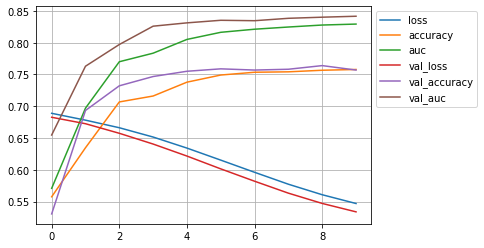

In [ ]:
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

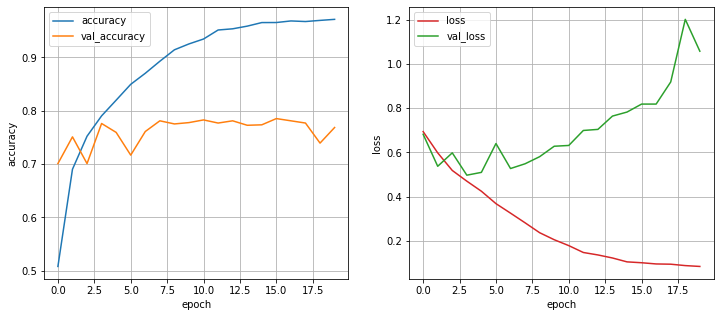

In [ ]:
base = pd.read_csv(LOG_DIR + 'v1-base.csv')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
base[['accuracy', 'val_accuracy']].plot(ax=ax0)
base[['loss', 'val_loss']].plot(ax=ax1, color=('tab:red', 'tab:green'))
ax0.set_xlabel('epoch')
ax1.set_xlabel('epoch')
ax0.set_ylabel('accuracy')
ax1.set_ylabel('loss')
ax0.grid()
ax1.grid()
plt.show()

14963 samples loaded


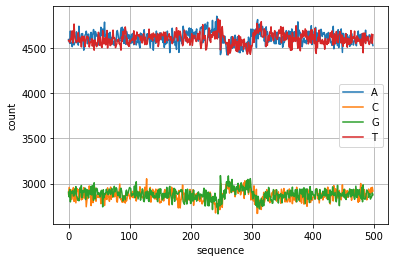

In [ ]:
x, y = load_fasta(files[0])
temp = pd.DataFrame([list(seq) for seq in x])
ax = temp.apply(pd.Series.value_counts, axis=0).T.plot()
ax.set_xlabel('sequence')
ax.set_ylabel('count')
ax.grid()